In [25]:
import torch
import torch.nn as nn

#Méthode de la pénalité de gradient

#Pénalité qui sera ajoutée au "loss" du discriminateur, pour maintenir une norme de ses gradients proche de 1.
def gradient_penalty(critic, labels, real, fake, device="cpu"): 
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, labels)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),create_graph=True,retain_graph=True,)[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [1]:
"""
Discriminator and Generator implementation from DCGAN paper
"""
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

#Discriminateur model
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes,img_size): #Addition de labels
      
        super(Discriminator, self).__init__()

        self.img_size = img_size

        self.disc = nn.Sequential(
            # entrées : N x channels_img x 64 x 64
            nn.Conv2d(channels_img +1, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1), # Sortie de taille 4x4 
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),nn.Sigmoid(),) #Taille 1x1
            
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),)

    def forward(self, x, labels): #Ajout de labels 
      embedding = self.embed(labels).view(labels.shape[0], 1,self.img_size,self.img_size)
      x = torch.cat([x, embedding], dim=1) 
      return self.disc(x)


#Generator model
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g,num_classes,img_size,embed_size):
        super(Generator, self).__init__()


        self.img_size = img_size
        self.net = nn.Sequential(
            # Entrée de taille 1x1
            self._block(channels_noise+ embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),)# Sortie de taille 64x64
        self.embed=nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),)

    def forward(self, x,labels):
      embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
      x = torch.cat([x, embedding], dim=1)
      return self.net(x)

#initialisation des poids
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success")
#test() 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import numpy as np 
from torch.autograd import Variable

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS_IMG = 1
NUM_CLASSES=10 #Ajout de classes
GEN_EMBEDDING=100
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5



transforms = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor(),transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),])


#Pour print() la loss à la fin + images
img_list = [] #Va contenir les images durant l'entraînement
G_losses = []
D_losses = []

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,)


# Initialisation generator/discriminator
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_CRITIC,NUM_CLASSES, IMG_SIZE).to(device)


initialize_weights(gen)
initialize_weights(disc)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
criterion = nn.BCELoss() #Définition de la loss

# for tensorboard plotting
fixed_noise = torch.randn(64, Z_DIM, 1, 1).to(device) #Bruit fixé
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    
    for batch_idx, (real, labels) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels= labels.to(device) #Ajout de labels
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device) #Ajout de bruits
        fake = gen(noise,labels)

        ### Entraînement du discriminateur : max log(D(x)) + log(1 - D(G(z)))

        disc_real = disc(real, labels).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real)) #D(x)

        disc_fake = disc(fake.detach(), labels).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) #D(G(z)) 

        loss_disc = (loss_disc_real + loss_disc_fake)/2 #Loss du discriminator  --> moyenne des deux
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Entrainement du generateur
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device) #Ajout de bruits
        #fake_labels =torch.LongTensor(np.random.randint(0, 10, size=64)).cuda()
        fake = gen(noise,labels)

        gen_fake = disc(fake, labels).reshape(-1)
        loss_gen = criterion(gen_fake, torch.ones_like(gen_fake))#Loss du generateur
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print la loss/ sur tensorboard
        if batch_idx % 500 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

            with torch.no_grad():
                fake = gen(noise, labels)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            plt.title("Fake Images")
            plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()

        # Save Losses 
        G_losses.append(loss_gen.item())
        D_losses.append(loss_disc.item())

        step += 1

Output hidden; open in https://colab.research.google.com to view.

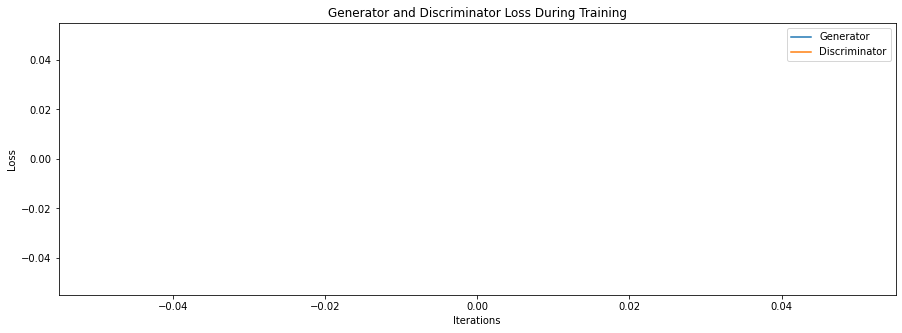

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
import numpy as np 

#Plot the fake images 
for i in range(len(img_list)):
  plt.figure(figsize=(20,20))
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(np.transpose(img_list[i].cpu(),(1,2,0)))
  plt.show()